# JDOT Domain Adaptation with Gaussian Distributions

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
import keras
from keras.layers import Dense
import ot

In [84]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the dataset

In [6]:
lb = preprocessing.LabelBinarizer()

### Source domain

In [7]:
N_source = [50, 50, 50] # number of points for the 2 classes

In [8]:
mean = 1*np.array([[-1,-1], [-1,1], [1,0]])
std = 0.1

In [9]:
X = []
X_source = np.concatenate([ot.datasets.get_2D_samples_gauss(N_source[i], mean[i], std) 
                           for i in range(len(N_source))], axis=0)

Y_source = np.concatenate([[i]*N_source[i] for i in range(len(N_source))])
Y_source_bin = lb.fit_transform(Y_source)

### Target domain

In [10]:
N_target = [50, 50, 50] # number of points for the 2 classes

In [11]:
angle = np.pi/4
rot_matrix = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
mean = np.dot(rot_matrix, mean.T).T
std = 0.1

In [12]:
X = []
X_target = np.concatenate([ot.datasets.get_2D_samples_gauss(N_target[i], mean[i], std) 
                           for i in range(len(N_target))], axis=0)

Y_target = np.concatenate([[i]*N_target[i] for i in range(len(N_target))])
Y_target_bin = lb.fit_transform(Y_target)

### Label binarization

### Display the dataset

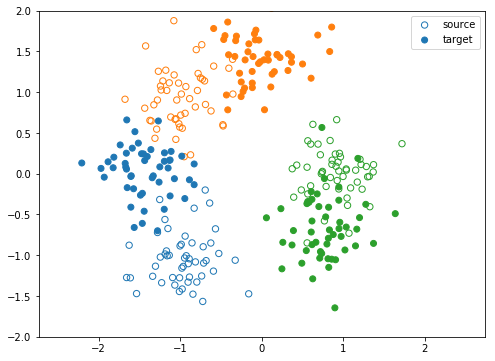

In [13]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.axis("equal")
plt.axis([-2,2,-2,2])

plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

## Initialization

### Model for the classifier

In [132]:
# model = Sequential()
# model.add(Dense(3, activation="softmax", input_dim=2))
# model.compile('adam','categorical_crossentropy')
model = LinearSVC()

In [133]:
# model.fit(X_source, Y_source_bin, batch_size=20, epochs=300)
model.fit(X_source, Y_source)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

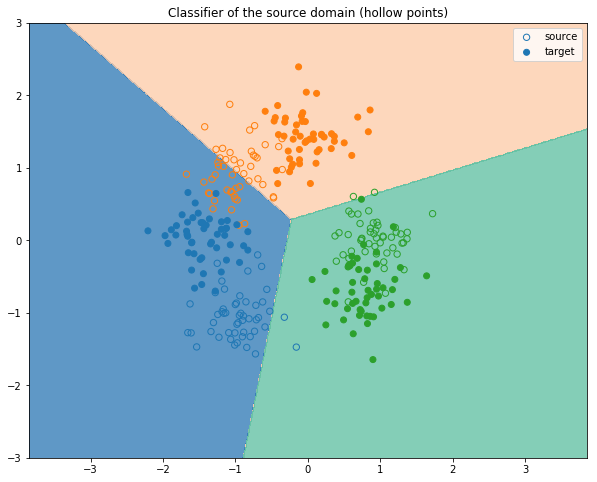

In [152]:
from matplotlib import colors

plt.rcParams['figure.figsize'] = (10, 8)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
#levels = np.linspace(0,1,20)
# cm = plt.cm.coolwarm
cm = colors.ListedColormap([plt.cm.Set1(1), plt.cm.Pastel2(1), plt.cm.Set2(0)])
# Z = lb.inverse_transform(model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
# plt.colorbar(cont, orientation="vertical")

plt.title("Classifier of the source domain (hollow points)")
plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])
plt.legend()

Z

In [149]:
xx

array([[-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99],
       [-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99],
       [-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99],
       ..., 
       [-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99],
       [-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99],
       [-4.  , -3.99, -3.98, ...,  3.97,  3.98,  3.99]])

In [150]:
yy

array([[-4.  , -4.  , -4.  , ..., -4.  , -4.  , -4.  ],
       [-3.99, -3.99, -3.99, ..., -3.99, -3.99, -3.99],
       [-3.98, -3.98, -3.98, ..., -3.98, -3.98, -3.98],
       ..., 
       [ 3.97,  3.97,  3.97, ...,  3.97,  3.97,  3.97],
       [ 3.98,  3.98,  3.98, ...,  3.98,  3.98,  3.98],
       [ 3.99,  3.99,  3.99, ...,  3.99,  3.99,  3.99]])

In [135]:
def f(x):
    return model.predict(x.reshape(1,2)).flatten()

### Label loss function

In [136]:
def label_loss(y, fx):
    if len(fx) == 1:
        fx = lb.transform(fx)
    fx = fx.flatten()
    return np.sum([y[i_class] * (1-fx[i_class])**2 + (1 - y[i_class]) * (-1 - fx[i_class])**2 
                   for i_class in range(len(y))])

### Hyperparameters

In [137]:
alpha = 1
batch_size = 150

wa = np.ones((batch_size,)) / batch_size
wb = np.ones((batch_size,)) / batch_size

a = np.ones((len(Y_source),)) / len(Y_source)
b = np.ones((len(Y_source),)) / len(Y_source)

## Run the algorithm

In [138]:
i = 0

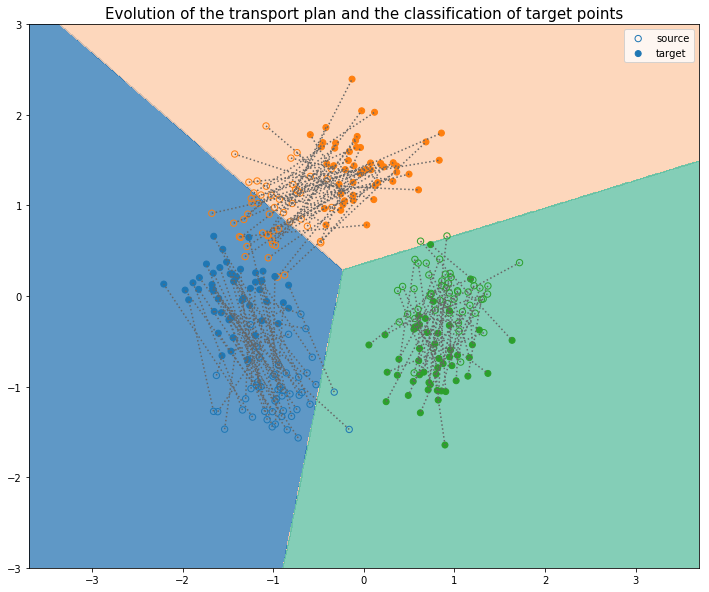

In [148]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.axis("equal")
plt.axis(3*np.array([-1,1,-1,1]))

nb_iter = 1

for i in range(i, nb_iter+i):
#     source_choice = np.random.choice(len(X_source), batch_size)
#     target_choice = np.random.choice(len(X_target), batch_size)

#     X_sample_source = X_source
#     Y_sample_source = Y_source
#     Y_sample_source_bin = Y_source_bin
#     X_sample_target = X_target
#     Y_sample_target = Y_target[target_choice]

    # Gamma part

    D = np.array([[np.linalg.norm(xs-xt) for xs in X_sample_source] for xt in X_sample_target])
    L = np.array([[label_loss(ys, f(xt)) for ys in Y_sample_source_bin] for xt in X_sample_target])
    C = alpha * D + L
    gamma = ot.emd(wa, wb, C)
   
    
    # f part
    
#     Y_hat = batch_size * gamma.T.dot(Y_sample_source)
#     Y_hat_bin = (1. / batch_size) * np.dot(gamma.T, Y_sample_source_bin)
#     Y_hat = lb.inverse_transform(Y_hat_bin)

#     model.fit(X_sample_target, Y_hat)
    
    # Plot
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    cont = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    plt.scatter(X_sample_source[:,0], X_sample_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_sample_source])
    plt.scatter(X_sample_target[:,0], X_sample_target[:,1], label="target", color=colormap[Y_hat])
    ot.plot.plot2D_samples_mat(X_sample_source, X_sample_target, gamma, color=plt.cm.Dark2(8), linestyle=":")
    plt.title("Evolution of the transport plan and the classification of target points", fontsize=15)
    plt.legend()
    
    plt.savefig("screenshots/gaussian-13.png")

In [92]:
colormap[Y_hat]

array(['#ff7f0e', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#ff7f0e', '#2ca02c', '#1f77b4', '#1f77b4', '#1f77b4',
       '#2ca02c', '#ff7f0e', '#ff7f0e', '#1f77b4', '#ff7f0e', '#1f77b4',
       '#ff7f0e', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#ff7f0e', '#1f77b4', '#1f77b4', '#2ca02c', '#1f77b4',
       '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4',
       '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e',
       '#ff7f0e', '#1f77b4', '#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e',
       '#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#ff7f0e',
       '#ff7f0e', '#1f77b4', '#ff7f0e', '#ff7f0e', 

## Display the result

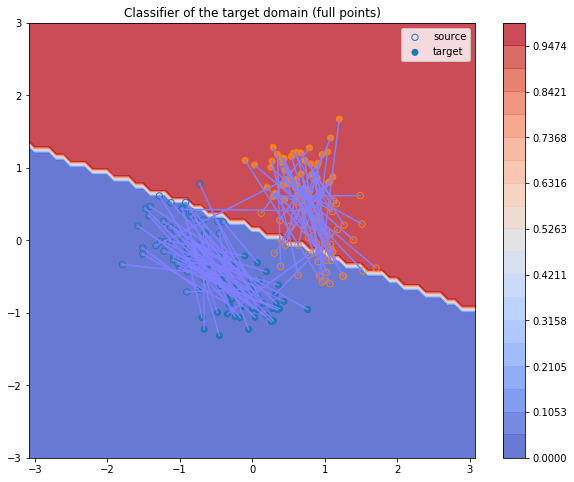

In [684]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.axis("equal")
plt.axis([-3,3,-3,3])

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
cont = plt.contourf(xx, yy, Z, levels, cmap=cm, alpha=.8)
plt.colorbar(cont, orientation="vertical")

D = np.array([[np.linalg.norm(xs-xt) for xs in X_source] for xt in X_target])
L = np.array([[label_loss(ys, f(xt.reshape(1,2))) for ys in Y_source] for xt in X_target])
C = alpha * D + L
gamma = ot.emd(a, b, C)
ot.plot.plot2D_samples_mat(X_source, X_target, gamma, color=[.5, .5, 1, 0.1]) # draw the segments


plt.title("Classifier of the target domain (full points)")
plt.scatter(X_source[:,0], X_source[:,1], label="source", s=40, facecolors='none', edgecolor=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], label="target", color=colormap[Y_target])

plt.legend()

## Debug

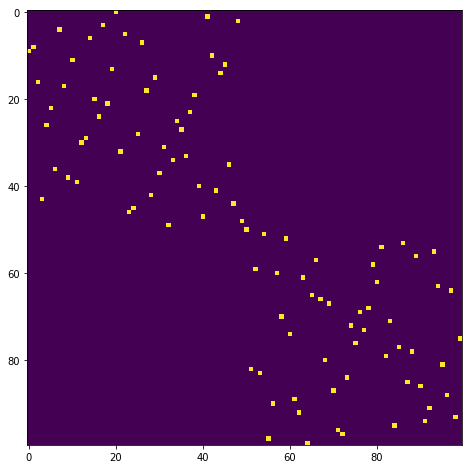

In [489]:
gamma = ot.emd(a, b, C)
plt.imshow(gamma, interpolation='nearest')

In [920]:
lb.transform(f(X_target[0].reshape(1,2))).flatten()

array([1, 0, 0])

In [1087]:
f(X_target[10])

array([ 0.33334652,  0.33332974,  0.33332375], dtype=float32)